# Carbon Modelling Practical

## Introduction

In this practical you will explore the characteristics and response of a model of the terrestrial carbon. At the end of this session, you should be able to better understand the theoretical material on Carbon models we covered in the lectures and explore how different types of vegetation respond to variations in environmental conditions.

The model implemented is based on that in JULES ([Best et al., 2011](http://www.geosci-model-dev-discuss.net/4/595/2011/gmdd-4-595-2011.html); [Clark et al., 2011](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html)) with some minor modifications. That model is in any case very similar to that of [Sellers et al. (1996)](SellersSib2.pdf). You should probably refresh your memory of the Sellers paper.

We will be using the class `photosynthesis` from the Python code [photJules.py](photJules.py). Embedded in the code, you will find a large number of parameters used to control the Carbon assimilation. These are grouped into 'typical' values (from the literature) for different Plant Functional Types (PFTs). The PFTs coded in this model are:

* `C3 grass`
* `C4 grass`
* `Broadleaf tree`
* `Needleleaf tree`
* `Shrub`

Table 2 in [Clark et al., 2011](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html) provides a summary of the default  PFT-dependent  photosynthesis parameters:
![Clark et al., 2011: figure 2](figures/jules-fig2.jpg)


Relating this to the previous practical, you might notice the variation in (leaf scale) single scattering albedo (`omega`) and the temperature ranges specified for the different PFTs.

## Photosynthesis model
    
Much of JULES is derived from  [Sellers et al. (1996)](SellersSib2.pdf). In this approach ((for C3, Collatz et al. (1991)), the leaf-level Carbon assimilation rate `W` is limited by:

* carboxylating rate `Wc`: the efficiency of the photosynthetic enzyme system (Rubisco-limited)

For $C_3$:

$$
W_c = V_{cmax} \left[ \frac{c_i - \Gamma^*}{c_i + K_c \left( 1 + \frac{O_2}{K_o} \right) } \right]
$$

For $C_4$:

$$
W_c = V_{cmax} 
$$

which may be further be limited by water stresses (not implemented here).

* light-limiting rate `We`: the amount of PAR captured by the leaf chlorophyll

For $C_3$:


$$
W_e = (F_{\pi} \cdot n) \alpha \left( 1 - \omega \right) \left[ \frac{c_i - \Gamma^*}{c_i + 2 \Gamma^* } \right]
$$

For $C_4$:

$$
W_e = (F_{\pi} \cdot n) \alpha \left( 1 - \omega \right)
$$

with $F_{\pi}$ the incident PAR vector and $n$ the leaf normal vector.

* transport rate  `Ws`: the capacity of the leaf to export or utilize the products of photosynthesis

For $C_3$:

$$
W_s = \frac{V_{cmax}}{2}
$$


For $C_4$:

$$
W_s = \frac{2\times 10^4 \times V_{cmax} \times  c_i}{p}
$$

with $p$ the atmospheric pressure (Pa).


A dark respiration rate, `Rd` is subtracted from the assimilation. 

A scalar control on `Ws` and `Wc` is `Vcmax`, the maximum rate of carboxylation of Rubisco. This is in turn scaled by the leaf Nitrogen parameter (`n0`). It is modulated by temperature relative to the temperature range constraints. 

The light-limited rate `We` is defined by the product of the quantum efficiency `alpha`, the PAR absorption rate (`ipar`) projected onto a leaf surface, and the leaf absorptance (1 - `omega`), where `omega` is the leaf single scattering albedo. 

For C3 plants, `We` and `Wc` are modulated by internal leaf CO2 concentration effects that are functions of `Gamma`, the CO2 compensation point without leaf respiration. For `Wc`, additional parameters, the Michaelis-Menton constants for CO2 and O2, come into play. These are in turn functions of temperature.

For C4 plants, `Ws` is directly scaled by internal leaf CO2 concentration relative to surface pressure.

The product of `Vcmax` and the PFT-specific factor `fdr` give dark respiration.

## The code

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from photJules import photosynthesis
from photter import plotme,day_plot
from solar import solar_model

A starting point is to produce a function that uses the model in an easy way. The function `do_photosynthesis` does just that. It takes a large number of options, and allows us to do different plots, etc. The parameters are:

* `ipar`: Incoming radiation in units of $\mu mol\, m^{−2}s^{−1}$ (default: 200)
* `Tc`: Temperature in Celsius
* `co2_ppmv`: $CO_2$ concentration in units of ppmv
* `n`: Length of array (default value: 100 bins)
* `pft_type`: type of PFT (see JULES paper for details)
* `plotter`: None or dictionary of plotting options
* `x` : array to be used for $x$-axis for plots (or None in which case the Tc array is used)

The plotting dictionary is of the form:

    plot_dict = {
        n_subplots : 1,       # number of sub-plots
        subplot    : 0,       # index of this sub-plot
        title      : 'title', # subplot title
        name       : 'name',  # plot file name 
        xlabel     : 'x label'# x label   
        log        : False    # use log scale for y axis
    }
    
 The function returns:
 
     photo,plotter
     
where `photo` contains the model calculations and `plotter` an updated plotting dictionary.

The main outputs are (all in $mol \ m^{-2} s^{-1}$):

* `Wc` : carboxylating rate 
* `We` : light-limiting rate 
* `Ws` : transport rate 
* `W` : combined rate 
* `Al` : assimilation rate 
* `Rd` : dark respiration rate

all accessible as `photo.Wc` etc.


In [2]:
def do_photosynthesis(ipar=200.,Tc=None,co2_ppmv=390,n=100,
          pft_type='C3 grass',plotter=None,x=None):
    '''
    A function to run the photosynthesis model. 
    
    Function allows the user to change
    a number of important photosynthesis parameters: 
    
    incoming PAR radiation, canopy temperature, CO2 concentration, 
    C3/C4 pathway and the PFT type. The first three
    parameters can be provided as arrays.
    
    The function will produce a plot of the variation
    of photosynthesis as it sweeps over the parameter range.
    '''
    from photJules import photosynthesis
    photo = photosynthesis()
    photo.data = np.zeros(n)

    # set plant type to C3
    if pft_type == 'C4 grass':
        photo.C3 = np.zeros([n]).astype(bool)
    else:
        photo.C3 = np.ones([n]).astype(bool)
    
    photo.Lcarbon = np.ones([n]) * 1
    photo.Rcarbon = np.ones([n]) * 1
    photo.Scarbon = np.ones([n]) * 1

    # set pft type
    # options are:
    # 'C3 grass', 'C4 grass', 'Needleleaf tree', 'Shrub'
    # 'Broadleaf tree'
    # Note that if C4 used, you must set the array
    # self.C3 to False

    photo.pft = np.array([pft_type]*n)

    # set up Ipar, incident PAR in (mol m-2 s-1)
    photo.Ipar = np.ones_like(photo.data) * ipar * 1e-6

    # set co2 (ppmv)
    photo.co2_ppmv = co2_ppmv*np.ones_like(photo.data)

    # set up a temperature range (C)
    try:
        if Tc is None:
            photo.Tc = Tc or np.arange(n)/(1.*n) * 100. - 30.
        else:
            photo.Tc = Tc
    except:
        photo.Tc = Tc
    
    # initialise
    photo.initialise()
    # reset defaults
    photo.defaults()

    # calculate leaf and canopy photosynthesis
    photo.photosynthesis()
    try:
        if x == None:
            x = photo.Tc
    except:
        pass
    plotter = plotme(x,photo,plotter)
    
    return photo,plotter


### Running Experiments

We can run the photosynthesis for one or more PFT and plot results as a function of temperature by setting the PFT keyword to one of the following:

* `C3 grass`
* `C4 grass`
* `Broadleaf tree`
* `Needleleaf tree`
* `Shrub`



>>> Saved result in photter_default.png


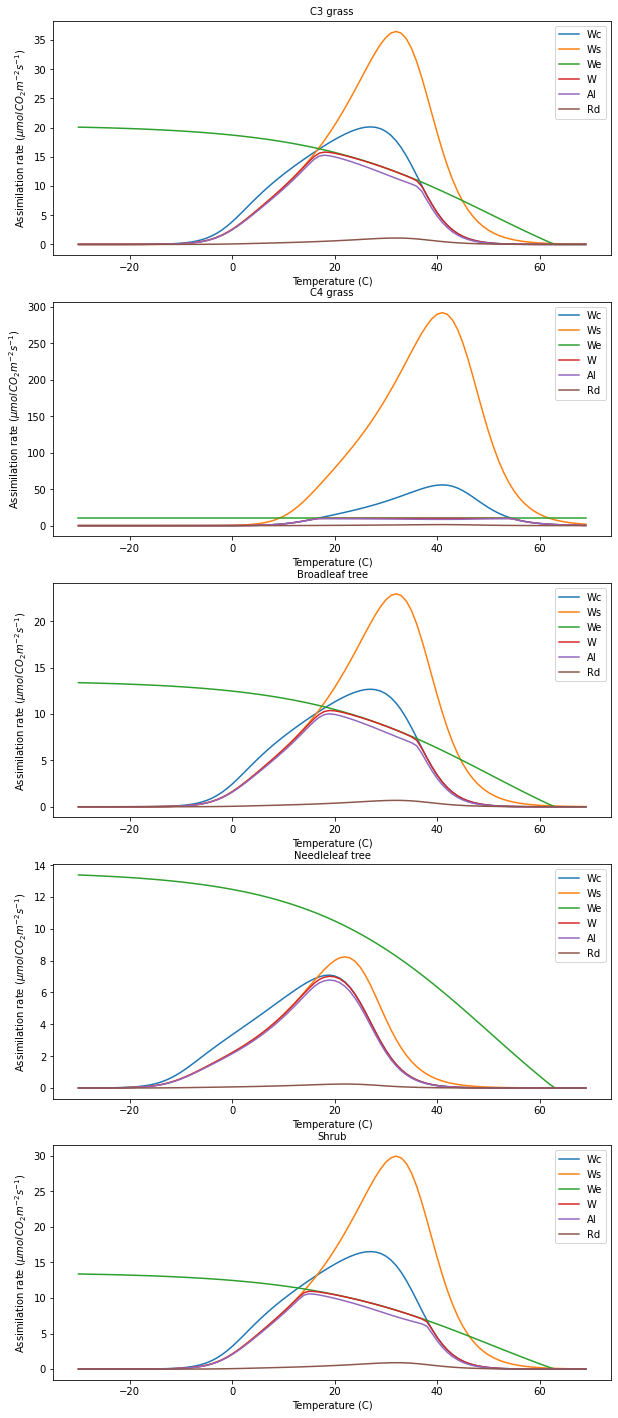

In [3]:
# list of all pfts
pfts = ['C3 grass','C4 grass',\
            'Broadleaf tree','Needleleaf tree','Shrub']

plotter = {
    'n_subplots' : len(pfts),  # number of sub-plots
    'name'       : 'default',  # plot name
    'ymax'        : None      # max value for y set
}

# store the data for each PFT in a dictionary
output = {}
# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(pft_type=pft,plotter=plotter)

We can access the data generated from the variable `photo`, e.g. for `Wl`:

In [4]:
print(output['C4 grass'].We * 1e6)
# or eg  maximum value using .max()
print(f"max We value for C3 grass {output['C3 grass'].We.max() * 1e6} umolCO2m-2s-1")

[9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96
 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96
 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96
 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96
 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96
 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96
 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96 9.96
 9.96 9.96]
max We value for C3 grass 20.07264113525945 umolCO2m-2s-1


### Experiment 1: What controls leaf-level photosynthesis?||

#### Exercise

**Light-limiting assimilation**

We repeat Table 2 from [Clark et al., 2011](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html) for convenience:

![Clark et al., 2011: figure 2](figures/jules-fig2.jpg)



From the data in this table and your understanding of the controls on photosynthesis in the model, answer the following questions and confirm your answer by running the model.

* which PFT has the highest values of `We`, and why?
* How does this change with increasing `ipar`?
* When ipar is the limiting factor, how does assimilation change when ipar increases by a factor of k?
* For C3 grasses, what are the limiting factors over the temperatures modelled for ipar=200?
* For C3 grasses, what are the limiting factors over the temperatures modelled for ipar=400?
* For C4 grasses, what are the limiting factors over the temperatures modelled? 

In [5]:
#### ANSWER

msg = f'''
which PFT has the highest values of We, and why?

From the notes, product of the quantum efficiency alpha, 
the PAR absorption rate (ipar) and the leaf absorptance 
(1 - omega, where omega is the leaf single scattering albedo).

So, for given ipar, it is controlled by the product of
alpha and (1 - omega).

The C3 plants have the same value of omega here (0.15)
so 1 - omega = 0.85. For C4, this is 0.83.

C3 grasses have the highest value of alpha (0.12).

So, 
For C3 max, we have alpha * (1 - omega) = 0.85 * 0.12 = {0.85 * 0.12}
For C4    , we have alpha * (1 - omega) = 0.83 * 0.06 = {0.83 * 0.06}

so, C3 grasses should have the highest We.

The other C3 plants should have the same We curves.

We can demonstrate this:

Maximum We for each PFT for default CO2 and ipar
'''

print(msg)

# list of all pfts
pfts = ['C3 grass','C4 grass',\
            'Broadleaf tree','Needleleaf tree','Shrub']
# store the data for each PFT
output = {}
# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(ipar=200,pft_type=pft)
    print(pft,output[pft].We.max() * 1e6,'umolCO2m-2s-1')
    
    


which PFT has the highest values of We, and why?

From the notes, product of the quantum efficiency alpha, 
the PAR absorption rate (ipar) and the leaf absorptance 
(1 - omega, where omega is the leaf single scattering albedo).

So, for given ipar, it is controlled by the product of
alpha and (1 - omega).

The C3 plants have the same value of omega here (0.15)
so 1 - omega = 0.85. For C4, this is 0.83.

C3 grasses have the highest value of alpha (0.12).

So, 
For C3 max, we have alpha * (1 - omega) = 0.85 * 0.12 = 0.102
For C4    , we have alpha * (1 - omega) = 0.83 * 0.06 = 0.0498

so, C3 grasses should have the highest We.

The other C3 plants should have the same We curves.

We can demonstrate this:

Maximum We for each PFT for default CO2 and ipar

C3 grass 20.07264113525945 umolCO2m-2s-1
C4 grass 9.959999999999997 umolCO2m-2s-1
Broadleaf tree 13.381760756839634 umolCO2m-2s-1
Needleleaf tree 13.381760756839634 umolCO2m-2s-1
Shrub 13.381760756839634 umolCO2m-2s-1


In [6]:
#### ANSWER
msg = '''
How does this change with increasing ipar?

It scales with ipar, so increasing ipar increases We

'''
print(msg)
output = {}
pfts = ['C3 grass','C4 grass']
for pft in pfts:
    output[pft],plotter = do_photosynthesis(pft_type=pft,ipar=200.)
    print(pft,'ipar=200',output[pft].We.max() * 1e6,'umolCO2m-2s-1')
    output[pft],plotter = do_photosynthesis(pft_type=pft,ipar=400.)
    print(pft,'ipar=400',output[pft].We.max() * 1e6,'umolCO2m-2s-1')


How does this change with increasing ipar?

It scales with ipar, so increasing ipar increases We


C3 grass ipar=200 20.07264113525945 umolCO2m-2s-1
C3 grass ipar=400 40.1452822705189 umolCO2m-2s-1
C4 grass ipar=200 9.959999999999997 umolCO2m-2s-1
C4 grass ipar=400 19.919999999999995 umolCO2m-2s-1


In [7]:
#### ANSWER

msg = '''
When ipar is the limiting factor, how does assimilation change 
when ipar increases by a factor of k?

This is almost the same question as above:

When ipar is the limiting factor (for all cases) it scales
directly with the value of ipar -- so increasing ipar by a factor of 
k will increase assimilation by that same factor.
'''
print(msg)


When ipar is the limiting factor, how does assimilation change 
when ipar increases by a factor of k?

This is almost the same question as above:

When ipar is the limiting factor (for all cases) it scales
directly with the value of ipar -- so increasing ipar by a factor of 
k will increase assimilation by that same factor.



>>> Saved result in photter_default.png

With ipar=200 and co2_ppmv=390, we have the same graph we saw earlier.
The limiting factors are Ws up to around 17 C 
(close to We value), then We to around 36 C
then Wc. At moderate temperatures then, and low ipar, 
light is the main limiting factor. At lower temperatures
it is transport-limited (almost the same as carboxylation)
and at higher tempertures it is limited by carboxylation.



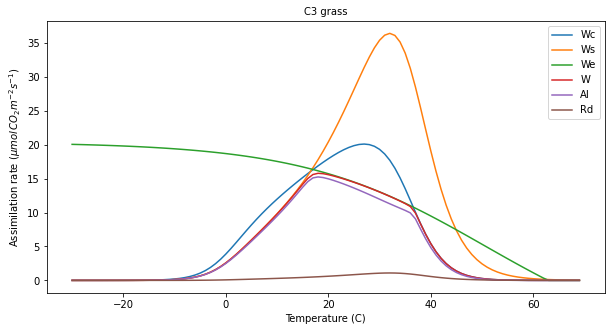

In [8]:
### ANSWER
msg = '''
For C3 grasses, what are the limiting factors over the temperatures modelled for ipar=200?
'''

# list of all pfts
pfts = ['C3 grass']

plotter = {
    'n_subplots' : len(pfts),       # number of sub-plots
    'name'       : 'default',  # plot name
    'ymax'        : None      # max value for y set
}

# store the data for each PFT
output = {}
# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(ipar=200,pft_type=pft,plotter=plotter)
    
msg = '''
With ipar=200 and co2_ppmv=390, we have the same graph we saw earlier.
The limiting factors are Ws up to around 17 C 
(close to We value), then We to around 36 C
then Wc. At moderate temperatures then, and low ipar, 
light is the main limiting factor. At lower temperatures
it is transport-limited (almost the same as carboxylation)
and at higher tempertures it is limited by carboxylation.
'''
print(msg)

>>> Saved result in photter_default.png

With ipar=400 and co2_ppmv=390, we have removed the
light limitation. The main shape follows closely
that of Wc, though up to around 17 C it is
actually Ws that is limiting here.



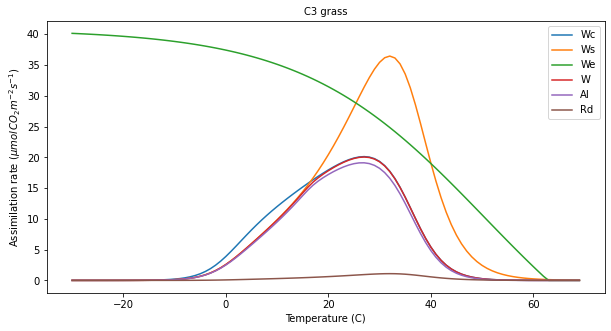

In [9]:
### ANSWER
msg = '''
For C3 grasses, what are the limiting factors over the temperatures modelled for ipar=400?
'''

# list of all pfts
pfts = ['C3 grass']

plotter = {
    'n_subplots' : len(pfts),       # number of sub-plots
    'name'       : 'default',  # plot name
    'ymax'        : None      # max value for y set
}

# store the data for each PFT
output = {}
# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(ipar=400,pft_type=pft,plotter=plotter)
    
msg = '''
With ipar=400 and co2_ppmv=390, we have removed the
light limitation. The main shape follows closely
that of Wc, though up to around 17 C it is
actually Ws that is limiting here.
'''
print(msg)

>>> Saved result in photter_default.png

With ipar=200 and co2_ppmv=390, we have the same graph we saw earlier.
The limiting factors are Wc up to around 17 C and after 36 C. 
For moderate temperatures, it is light limited. The light-limited rate
defines the maximum assimilation rate.



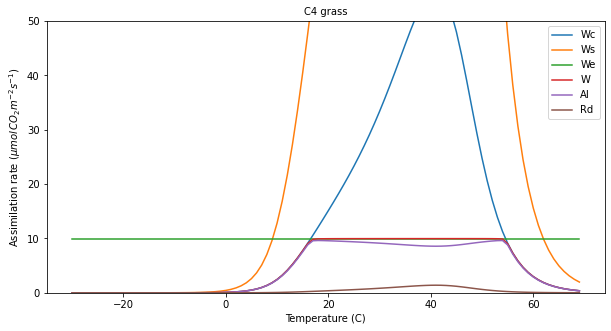

In [10]:
### ANSWER
msg = '''
For C4 grasses, what are the limiting factors over the temperatures modelled?
'''

# list of all pfts
pfts = ['C4 grass']

# set ymax here to be able to see the plots
plotter = {
    'n_subplots' : len(pfts),       # number of sub-plots
    'name'       : 'default',  # plot name
    'ymax'        : 50      # max value for y set
}

# store the data for each PFT
output = {}
# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(ipar=200,pft_type=pft,plotter=plotter)
    
msg = '''
With ipar=200 and co2_ppmv=390, we have the same graph we saw earlier.
The limiting factors are Wc up to around 17 C and after 36 C. 
For moderate temperatures, it is light limited. The light-limited rate
defines the maximum assimilation rate.
'''
print(msg)

>>> Saved result in photter_default.png

As we increase ipar, we reduce the temperature range at which 
light limitation kicks in, and increase the maximum rate
proportionately by the proportionate increase in ipar. 



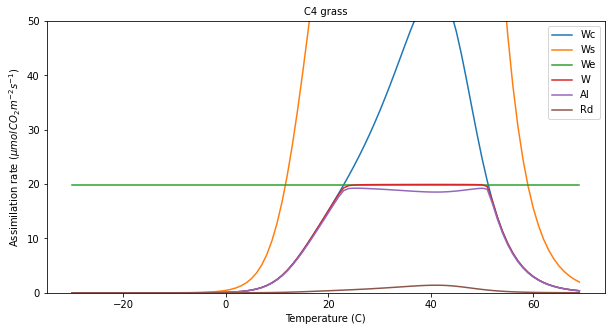

In [11]:
#### ANSWER

# list of all pfts
pfts = ['C4 grass']

# store the data for each PFT
output = {}
# set ymax here to be able to see the plots
plotter = {
    'n_subplots' : len(pfts),       # number of sub-plots
    'name'       : 'default',  # plot name
    'ymax'        : 50      # max value for y set
}

# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(ipar=400,pft_type=pft,plotter=plotter)
    
msg = '''
As we increase ipar, we reduce the temperature range at which 
light limitation kicks in, and increase the maximum rate
proportionately by the proportionate increase in ipar. 
'''
print(msg)

## Diurnal variations

We now include a model of solar radiation to examine diurnal variations. We use the [PyEphem](http://rhodesmill.org/pyephem/) Python package, which allows us to calculate the position of the sun with respect to an observer on Earth. So we need time as well as longitude and latitude.

Once we have this functionality, let's see plot how inputs and outputs to the carbon assimilation model change over a day. For example, the first of January 2012, and over London (latitude of 51 degrees).

We first call the `solar_model` method with the relevant parameters. This provides us with the time axis in units of Julian days, as well as the solar zenith angle (in degrees), the Earth-Sun distance, as well as the solar radiation in mol(phtons)/m^2s.

We can then calculate the amount of incoming PAR. To do this, we assume:
* that PAR is around 50% of total downwelling radiation,
* that the optical thickness of the atmosphere in the PAR region is 0.2
* and that we multiply by all this by $\cos(sza)$ to project on to a flat surface.

The next snippet generates the following plots:

1. the cosine of the solar zenith angle as a function of time
2. the incoming solar radiation in the PAR region
3. the different components that the photosynthesis model calculates
4. the C assimilation rate over the course of a day

<div class="alert alert-block alert-warning">

The last statement in the code snippet saves the entire figure into a PNG file that you can easily browse in the Jupyter notebook file navigation browser tab. The filename by default will be `assimilation_20120101.png`. You can add code similar to this at the end of each code block to save the whole image as a plot for reference later. E.g., just change the filename, leaving the `.png` extension in place.

`plt.savefig("my_filename.png", dpi=150, bbox_inches="tight")`

</div>


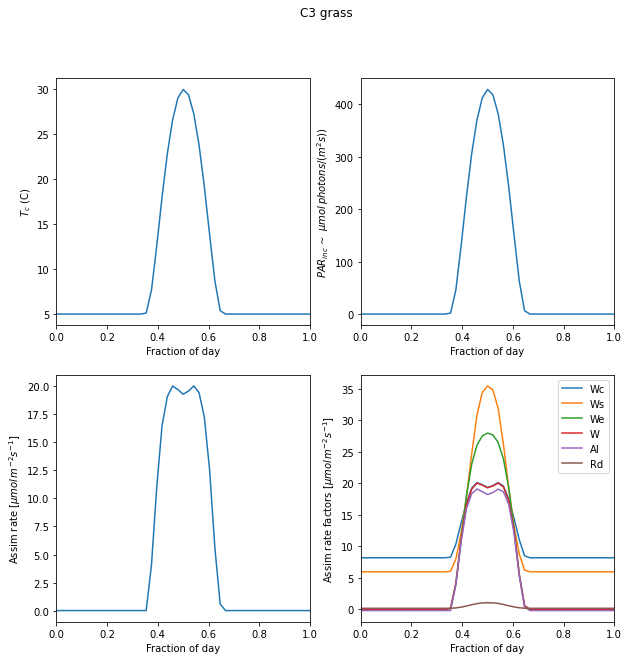

In [14]:
import numpy as np


# Calculate solar position over a day, every 30 mins
# for somewhere like London (latitude 51N, Longitude=0)
latitude = 51.
longitude = 0.0


jd, sza, distance, solar_radiation = solar_model(
    0.,np.array([0.,30.]),np.arange(25),1,1,2012,
    latitude, longitude)
mu = np.cos(np.deg2rad(sza))

#tau:     optical thickness (0.2 default)
#parprop: proportion of solar radiation in PAR
#Tmin:    min temperature (C) 5.0 default
#Tmax:    max temperature (C) 30.0 default
        
tau=0.2
parprop=0.5

ipar = solar_radiation* parprop * np.exp(-tau/mu) * mu  # u mol(photons) / (m^2 s)
# mock up a Tc term
# normalised ipar term
Tmin=5.0
Tmax=30.0
surrogate = (ipar-ipar.min())
surrogate = surrogate/surrogate.max()
Tc = surrogate*(Tmax-Tmin) + (Tmin)
pft = "C3 grass"

p = do_photosynthesis(n=len(ipar), pft_type=pft,Tc=Tc, \
                      ipar=ipar,co2_ppmv=390,\
                      x=ipar,plotter=None)[0]

day_plot(jd,ipar,Tc,p,title=pft)

This is quite an interesting figure! If the only thing that varies over the day is the solar radiation intensity, then at this time and latitude, the (leaf) assimilation is ‘pulse’-like over the day: its is limited by light intensity at high solar zenith angles (early morning and late afternoon), then essentially flat.

Normally, the temperature will vary over the day as well, so we could e.g. assume a dependence on solar zenith angle:

In [ ]:
# make temperature a function of cos(solar zenith)
temp = 35. * mu

p = do_photosynthesis(n=len(ipar),Tc=temp, name='c', \
                  ipar=ipar,co2_ppmv=390,x=ipar,xlabel='',plot=None)
sp = plt.subplot( 2, 1, 1 )
sp.plot(jd,temp, '-')
sp.set_xlabel('Fraction of day')
sp.set_ylabel('Temperature $[^{\circ}C]$')


sp = plt.subplot( 2, 1, 2 )
sp.plot(jd,(p.Al+p.Rd)*1e6, '-')
sp.set_ylabel('Assim rate $[\mu mol\, m^{-2} s^{-1}]$')
sp.set_xlabel('Fraction of day')

Now we have dramatically reduced the temperature (remember, the temperature we had before was $25^{\circ}C$ constantly through the day. It now oscillates between 0 and $9^{\circ}C$) so we see a general lowering of the assimilation rate, but we also see a change in the shape.

### Exercise 2

<div class="alert alert-block alert-info">
Using codes similar to those above, explore diurnal variations in leaf assimilation rate at different latitudes and different times of year, for different PFTs (hint: once you have set this up for one example, it should be easy to run for multiple cases).

If possible, you should try to explain what the limiting factors are in each case (hint: plot terms other that `p.Al`, such as `p.Wc`, `p.Wl`, `p.We`).

It would be interesting to summarise such results by calculating the total (leaf) assimilation over the day (N.B. in the above examples, $Al$ is sampled every half hour over the day: you want a result in μmol/m2).

When performing this experiment, think about other complexities that might arise (e.g. how does the idea of phenology fit into this?)
</div>

## Canopy scale assimilation

All of the above experimentation was just at the leaf level. We have essentially looked at responses to temperature and light intensity. Of course, in a ‘real’ canopy, there will be varying amounts of leaf area, so we have to consider how to scale up the leaf-level assimilation to the canopy scale.

Although there are various ways to scale from leaf-level assimilation to the canopy level, we have only implemented what is perhaps the simplest here. This is based on the assumption that there is an acclimatisation of leaf $N$ throughout the canopy (Sellers et al., 1992) giving:
$$
V_m = V_{m0} \overline{f(L)}
$$

where $\overline{f(L)}$ is the average fraction of absorbed PAR (as opposed to instantaneous) at leaf area index (LAI) $L$, $V_{m0}$ is the ‘maximum’ (top leaf) assimilation, and $V_m$ is the canopy-scale assimilation.

Assuming a homogeneous canopy, the canopy scale PAR use efficiency $\Pi$ is:

$$
\Pi = \int_{0}^{L} \overline{f(l)}\,dl. = \left[ \frac{1-e^{-\overline{k}L}}{\overline{k}} \right] = \frac{\overline{fAPAR}}{\overline{k}}
$$


where $\overline{fAPAR}$ is the (average) fraction of absorbed PAR by the canopy and $\overline{k}$ is an effective extinction coefficient:

$$
\overline{k} = \left[ \frac{G(\mu)}{\mu} \right] {(1-\omega_l)}^{\frac{1}{2}}
$$
with $\mu$ the cosine of the (time mean) solar zenith angle (a path length term), $G(\mu)$ the ‘Ross’ or ‘$G$’-function giving the average normalised leaf projection in the direction of the (time mean) incoming radiation, and $\omega_l$ is the leaf single scattering albedo (unity minus leaf absorption) in the PAR region (see Sellers et al., 1992 for more details).

Under these assumptions then, we can calculate canopy scale photosynthesis.

$$
GPP = A_l \frac{\overline{fAPAR}}{\overline{k}}.
$$


Suppose we have an amount of leaf carbon of 0.07 $kg\,C\,m^{−2}$ and a specific leaf density of 0.025 ($kg\,C\,m^{−2}$ per unit of LAI) that is constant throughout the canopy (giving a LAI of 0.07/0.025 = 2.8), and a $G$ gunction of 0.5 (e.g. a spherical leaf angle distribution). We can model this as:

In [ ]:
plt.figure(figsize=(15,15))
latitude = 51.
longitude = 0.0
jd, sza, distance, solar_radiation = solar_model(
    0.,np.array([0.,30.]),np.arange(25),
    np.arange(1, 366), 1, 2012,
    latitude, longitude)
sp = plt.subplot( 2, 3, 1 )
sp.plot(jd, np.cos(np.deg2rad(sza)), '-', lw=0.2)
sp.set_xlabel("DoY")
sp.set_ylabel('$\mu')


# assume PAR is 50% of downwelling radiation
# and atmospheric optical thickness of PAR is 0.2
# we multiply by cos(solar zenith) here to project
# onto a flat surface (a 'big leaf')

tau = 0.2
mu = np.cos(np.deg2rad(sza))
temp = 35.*mu
ipar = solar_radiation* 0.5 * np.exp(-tau/mu) * mu  # u mol(photons) / (m^2 s)
sp = plt.subplot( 2, 3, 2 )
sp.plot(jd,ipar, '-', lw=0.2)
sp.set_ylabel('$PAR_{inc}\,\sim$ $\mu mol\, photons/ (m^2 s))$')
sp.set_xlabel("DoY")

sp = plt.subplot( 2, 3, 3 )
sp.plot(jd, temp, '-', lw=0.2)
sp.set_xlabel("DoY")
sp.set_ylabel("Temperature $[^{\circ}C]")

# run the leaf level model
p = do_photosynthesis(n=len(ipar),Tc=temp,name='c',ipar=ipar,
                      co2_ppmv=390,plot=None)
sp = plt.subplot( 2, 3, 4 )
# now plot over days the leaf level response
sp.plot(jd, (p.Al + p.Rd)*1.0e6, '-', lw=0.2)
sp.set_xlabel("DoY")
sp.set_ylabel("Leaf Assim rate\n $[\mu mol\, m^{-2} s^{-1}]$")


# now we want the canopy level response

p.Lcarbon = 0.07 # kg C m-2
#self.sigmal = 0.025 # kg C m-2 per unit LAI for C3 grass
# for Needleleaf tree: 0.10
# for Broadleaf tree: 0.0375
# for others: 0.05
p.LAI = p.Lcarbon/p.sigmal

# leaf single scattering albedo
p.omega = 0.2

p.G = 0.5
p.mubar = np.mean(mu)
p.kbar = (p.G/p.mubar)*np.sqrt(1-p.omega)
p.fapar = 1 - np.exp(-p.kbar * p.LAI)
print (f'mubar = {p.mubar:.2f}')
print (f'kbar = {p.kbar:.2f}')
print (f'fapar = {p.fapar}')
# kg C m-2 s-1: conversion factor from Clark et al. 2011
p.GPP = 0.012 * (p.Al + p.Rd)* p.fapar / p.kbar

sp = plt.subplot( 2, 3, 5 )
# plot this
sp.plot(jd, p.GPP*1e6, '-', lw=0.2)
sp.set_xlabel("DoY")
sp.set_ylabel('GPP $[mg\,C m^{-2}s^{-1}]$')
plt.subplots_adjust(wspace=.5)


The Net Ecosystem Productivity needs the plant respiration terms to be subtracted from the GPP. This is typically split into mainenance and growth respiration: $R_{pm}$ and $R_{pg}$ respectively. In Jules, $R_{pg}$ is assumed to be a fixed fraction of NPP:
$$
R_{p} = R_{pm} + R_{pg}
$$

$$
R_{pg} = r_g\Pi_{G}
$$


where $\Pi_{G}$ is the GPP (the canopy scale assimilation). In Jules, $r_g$ is set to 0.25 for all PFTs (Clark et al., 2011). Leaf maintenance respiration in Jules is the (moisture-modified, through a term $\beta$ that we have not dealt with here) canopy dark respiration (i.e. canopy-scaled). Root and stem respiration are set to depend on the nitrogen concentrations of the root and stem relative to the leaf nitrogen.

Since we have not introduced stem and root biomass yet, we will assume here that leaf, root and (respiring) stem biomass ($L$, $R$ and $S$ respectively) we will assume these terms equal for the moment, since we only require their relative amounts:
$$
R_{pm}=0.012\cdot R_{dc}\left[\beta+\frac{N_r + N_s}{N_l}\right]
$$
where:

$N_x$ is the Nitrogen concentration of biomass component $x$ and the factor 0.012 converts units (see Clark et al., 2011).

$$
N_l = n_m L
$$
$$
N_r = n_m R \mu_{rl}
$$
$$
N_s = n_m S \mu_{sl}
$$

where $\mu_{xl}$ is the relative Nitrogen concentartion of biomass component $x$ to leaf Nitrogen (assumed 1.0 here). $\beta=1$ for unstressed conditions. So:
$$
R_{pm}=0.012\cdot R_{dc}\left[\beta+\frac{R + S}{L}\right]
$$


In [ ]:
# NPP calculation
p.rg = 0.25
# scale Rd (respiration in the light) up to canopy here
p.Rpm = 0.036 * p.Rd * p.fapar / p.kbar
# Gpp from above, introducing beta
p.PiG = 0.012*( p.Al - p.beta * p.Rd) * p.fapar / p.kbar
# Grow respiration is a fraction of (GPP - maint resp)
p.Rpg = p.rg * (p.PiG - p.Rpm)
# ensure Rpg is non negative
p.Rpg[p.Rpg < 0] = 0.
# total respiration
p.Rp = p.Rpm + p.Rpg
# NPP: calculated as the difference
p.Pi = p.PiG - p.Rp

plt.plot(jd,p.Pi*1e6, '-', lw=0.5)
plt.xlabel('DoY')
plt.ylabel('NPP $[mg\, C\, m^{-2} s^{-1}]$')

Since we have calcualted NPP and GPP, we can integrate them over the year:

In [ ]:
print('mean NPP = {:.4f} {:s}'.format(np.mean(p.Pi) * 24 * 60 * 60 *1e3,
                                      'g C m-2 day-1'))
print('mean GPP = {:.4f} {:s}'.format(np.mean(p.PiG) * 24 * 60 * 60 * 1e3,
      'g C m-2 day-1'))

# n seconds in year
nsec = 366 * 24 * 60 * 60.
integral = np.mean(p.Pi) * nsec * 1e3 # g C m-2 yr-1
print ("NPP = {:.8g} {:s}".format(integral*1000, 'g C/m2/yr'))


# The total land surface area of the Earth is around 0.292 * 510072000 km^2
# http://chartsbin.com/view/wwu
# so if this were the mean, we would have
global_npp = 0.292 * 510072000 * integral *1e-9
print("Global NPP (rough est.) = {:.6G} {:s}".format(global_npp, 'GT C yr-1'))

which is certainly an over-estimate by a factor of about 2 because we have assumed high LAI grasslands everywhere on the land surface, but is at least the right order of magnitude.

### Experiment 3

We have shown here how to introduce LAI (or leaf C) into the scaling up to canopy GPP, and also how respiration terms in a model such as Jules can be calculated, which allows us to estimate canopy NPP.

The next parts of a model of this sort include partitioning of the NEP among biomass pools and applying phenological controls.

You could assume a simple, fixed proportion of partitioning of assimilates (e.g. $1/3$ to leaf, root and (respiring) stem biomass pools (i.e. each day, if NPP is positive, you add $1/3$ of the NPP (integrated over 24 hours = 24*60*60 seconds) to the leaf carbon pool (`p.Lcarbon`)). This then increases the LAI.

Since the canopy scaling model here is very simple, it turns out to be just a scalar to $A_l$, so you can first calculate $A_l$ over each day of the year, then, starting at the begining of the time series, start to accumulate carbon (and produce LAI). This gives you a dynamic LAI model (albeit at this moment one that is not controlled by phenology) that you can then use for each daily sample to scale from leaf to canopy GPP and NPP. The only other term that you need to include is a leaf biomass loss (a leaf shedding term, and usually shedding terms for the other pools of carbon). In JULES, this is achieved by defining a leaf turnover rate $\gamma_{lm}$ which is temperature controlled but set to 0.25 (per year) for C3 grasses if the temperature is above a threshold (see p.710 of Clark et al.). We could (very simply) assume then a rate of leaf biomass loss of $0.25L/366$ per day (although in JULES, the rate is based on the maximum seasonal leaf biomass, but we use the actual leaf biomass L here).

<div class="alert alert-block alert-info">
This final exercise then, is to build a dynamic vegetation model, one that ‘grows’ leaf carbon by calculating NPP, allocating a proportion of this to the leaf C pool at the end of each day, then losing a proportion ($0.25L/366$) as litterfall. This should be quite feasible given the codes above, though you might not finish it in this session. If you do complete this, you will find it a very satisfying exercise ... to have created a model of growing plants that links the concepts we have discussed. Although this is a slightly simplified model, it is not greatly less sophisticated than the models currently used in DGVMs, and you can learn a lot by building and trying out a model of this sort.

Once you have built the model, demonstrate its application for some given latitude and (ideally) multiple PFTs.
</div>

### Experiment 4

<div class="alert alert-block alert-info">
Whilst it is an interesting exercise to build and use models of the sort we have created here, there are many flaws with such models. Think carefully about what insights you have gained into both the strengths and weaknesses of such models. You should read the references below carefully to see what criticisms there are in those papers (e.g. complexities about leaf to canopy scaling). You should also think carefully about the role that ‘fixed’ parameters for each PFT have in such models, bearing in mind what has been learned from plant traits databases such as that of Kattge et al., (2011) that was covered in the lecture on Terrestrial Ecosystem Modelling.
</div>
